In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

# from scipy.signal import convolve
# from scipy.signal.windows import gaussian
from astropy.convolution import convolve as convolve_astropy
from astropy.convolution import Box1DKernel, Gaussian1DKernel
import astropy.units as u
from astroquery.nist import Nist # atomic lines
from astroquery.linelists.cdms import CDMS # molecular lines?
from scipy.signal import medfilt

from astropy.io import ascii, fits

%matplotlib inline

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

# Things that should only have to be defined once, here at the top
---

In [90]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.0000100135

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x,ampl,center,std,b):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x - center)/std)**2)) + b

# Reduced and order-merged data filepath 
# Desktop path
# data_path = "A:\\Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged"

# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"
# File path for figures to live in
# Desktop path
# fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra"

# Laptop Path
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_figs\\standards_spectra"


# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
# merged_hops_files = glob.glob(data_path+"/mHOPS*.fits")
hops_table = pd.read_csv('./hops_table.txt') # csv of standards with file and Spectral Type, c/v TBA
hops_list = hops_table['Source']

In [91]:
# Determine the maximum length of flux arrays
max_flux_length = max(len(fits.getdata(file)[1]) for file in hops_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in hops_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in hops_list)
# Initialize flux_stack with NaN values

wavelen_stack = np.full((max_wavelen_length, len(hops_list)), np.nan)
flux_stack = np.full((max_flux_length, len(hops_list)), np.nan)
snr_stack = np.full((max_snr_length, len(hops_list)), np.nan)

# Fill flux_stack with flux data
for i, file in enumerate(hops_list):
    # Get data
    wavelen = fits.getdata(file)[0]
    flux = fits.getdata(file)[1]
    median_flux = medfilt(flux, kernel_size=51)
    norm_flux = flux#/median_flux

    snr = fits.getdata(file)[2]
    # Clean data a bit
    snr_min = 10 # Minimum SNR
    snr_max = 1e4 # Maxmimum SNR
    snr_cut = (snr > snr_min) & (snr < snr_max) # bitwise SNR masking

    flux_min = 0 # minimum flux
    flux_cut = flux > flux_min # bitwise flux masking

    wavelen_min = 1.98
    wavelen_max = 2.48
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    wavelen = wavelen[snr_cut & flux_cut & wavelen_cut]
    norm_flux = norm_flux[snr_cut & flux_cut  & wavelen_cut]
    
    wavelen_stack[:len(wavelen),i] = wavelen # wavelength arrays for each standard
    flux_stack[:len(norm_flux),i] = norm_flux # normalized flux arrays for each standard
    
    
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.0*u.um,2.48*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I,Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')
igrins_wav_cut = (lines_table['Observed'] > 1.92) & (lines_table['Observed'] < 2.48)

lines_table = lines_table[igrins_wav_cut]

na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'red']

# lines_table[fe1_mask] # check where some lines are

fwhm =$2 \sqrt{2*\ln(2)} \sigma$

$\sigma = \frac{\text{FWHM}}{2 \ln(2)}$

delta_lam of R~6000

R = lam/del_lam

del_lam = lam/R

In [191]:
# Generate wavelength, flux, and SNR data (replace this with your actual data)
wv, flux, snr = ig.get_fitsdata(hops_table['Source'][0])

# GNIRS resolution
# R = lam/del_lam
R_gnirs = 5900
del_lam = 2.166/R_gnirs # delta lambda

# Gaussian stuff
# fwhm = 2*np.sqrt(2*np.log(2))*sigma
sigma = (del_lam) /(2*np.sqrt(2*np.log(2))) # standard deviation
sigma_pix = sigma/spec_res # convert sigma to pixels

# Convolve the flux with the low-resolution kernel using Astropy
flux_conv_astropy = convolve_astropy(flux, Gaussian1DKernel(sigma_pix), boundary='extend')

sigma_pix

15.569075133517627

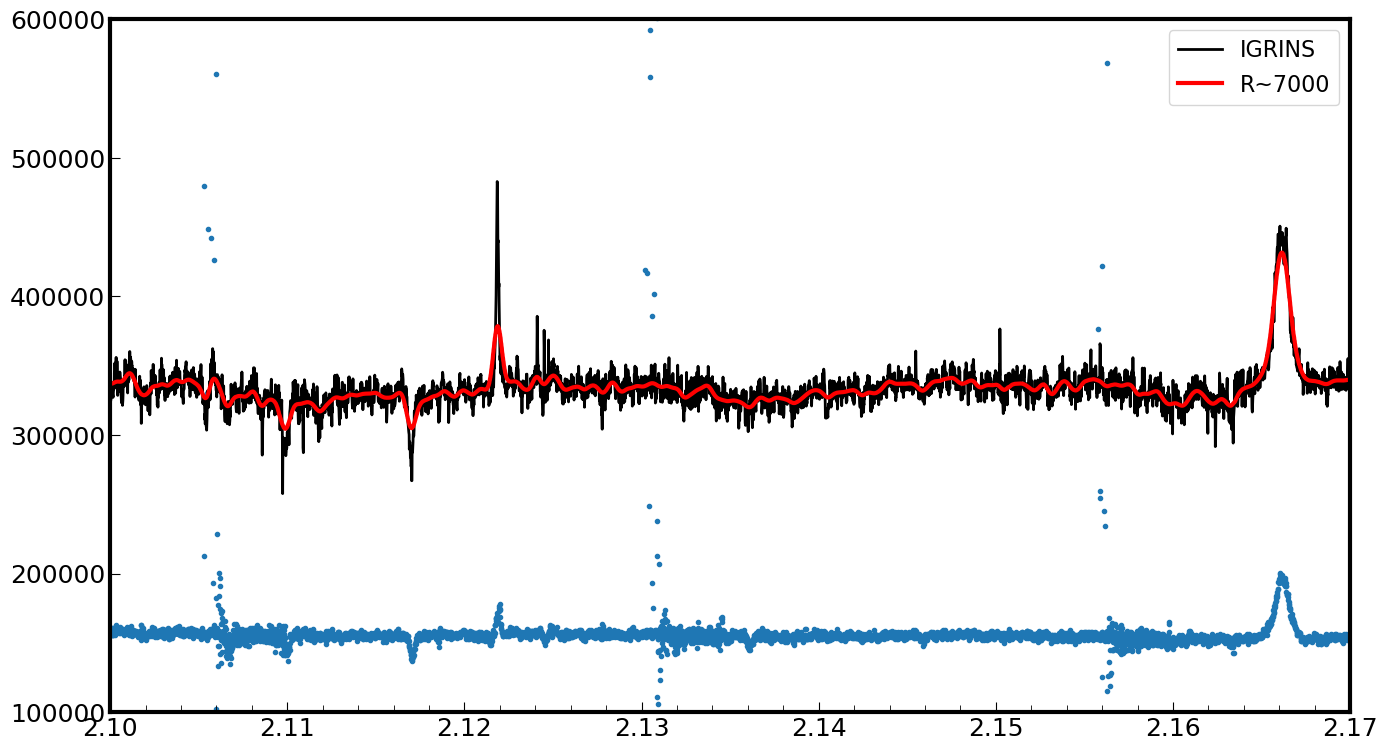

In [199]:
# Plot the results
fig = plt.figure(figsize=(16, 9))
plt.plot(wv, flux, ls='-', lw=2, c='black', label='IGRINS')
plt.plot(wv, flux_conv_astropy, ls='-', lw=3, c='red', label='R~7000') # not really
plt.scatter(hops70_wv,hops70_flux,marker='.')

plt.ylim(1e5,6e5)
plt.xlim(2.1, 2.17)
plt.legend()
plt.show()

Run through the K-band and plot spec_step segments of the spectra for each source

In [147]:
hops70_table = pd.read_csv('./HOPS70_30102016_K_0101_spec_A0v.txt',
              delim_whitespace=True, header=None, na_values='-NaN',
              names=['Order','Wavelength','Flux','SNR'],
              comment='#')

hops70_wv = hops70_table['Wavelength']
hops70_flux = hops70_table['Flux']

hops70_wv = hops70_wv[hops70_flux > 0]
hops70_flux = hops70_flux[hops70_flux > 0]

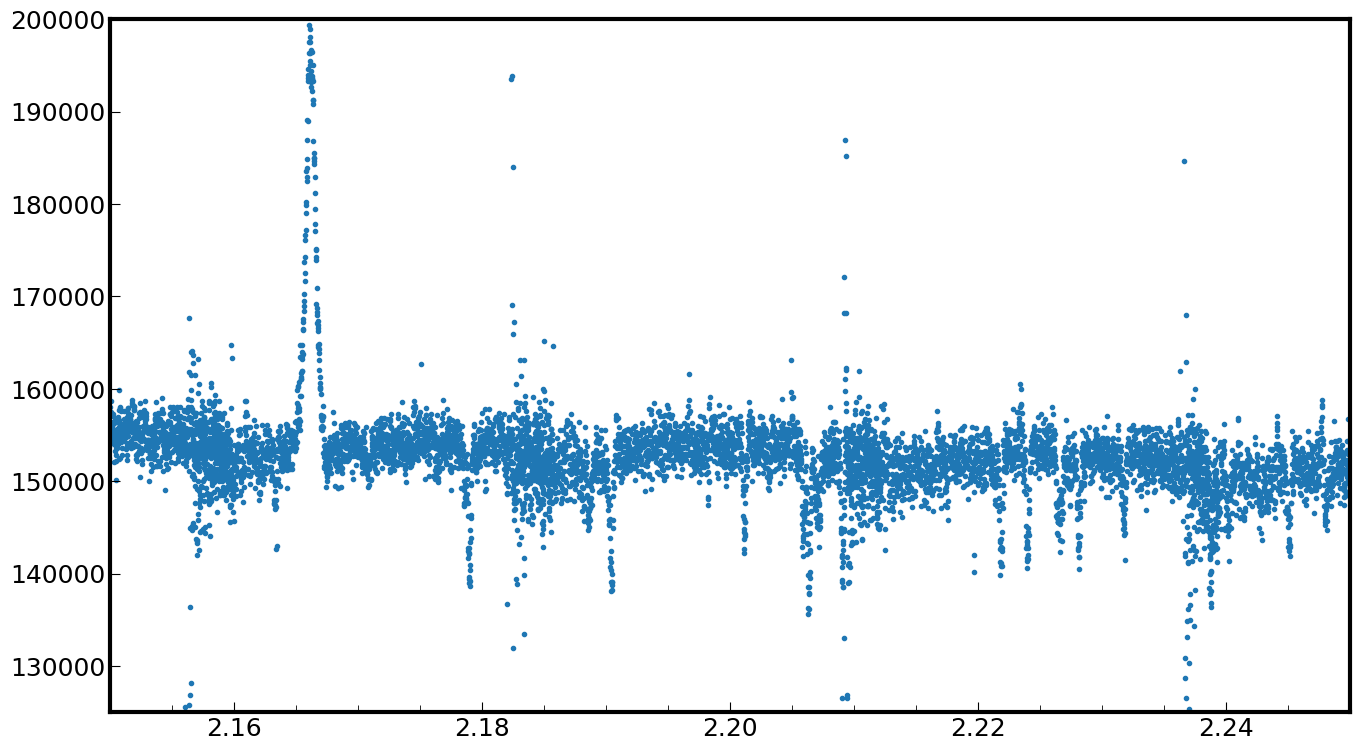

In [190]:
# Plot the results
fig = plt.figure(figsize=(16, 9))
plt.scatter(hops70_wv,hops70_flux,marker='.')
plt.xlim(2.15, 2.25)
plt.ylim(1.25e5,2e5)
plt.show()

In [98]:
# spec_step = 0.01 # micron steps
# # arange to step through the spectrum in spec_step micron increments
# test = np.arange(np.nanmin(wavelen_stack), np.nanmax(wavelen_stack), spec_step)
# # constant to separate the spectra  
# flux_const = np.linspace(0,1,len(hops_list))

# for start in test:
#     fig, ax = plt.subplots(figsize=(16, 9))
#     end = start + spec_step  # Determine end step

# # norm_flux = medfilt(flux,kernel_size = 51)
#     for standard in range(len(hops_list)):
#         mask = (wavelen_stack[:,standard] >= start) & (wavelen_stack[:,standard] < end)
#         # Plot spectrum and continuum fit
#         # ax.plot(wavelen[mask], norm_flux[mask]+flux_const[standard], '-.', c='black')#, label='Spectrum {}'.format(standard))
#         ax.plot(wavelen_stack[:,standard][mask],
#                 (flux_stack[:,standard][mask]),
#                 '-', c='black',lw=0.5,zorder=20)#, label='Spectrum {}'.format(standard))
#         # ax.set_xlim(start,end) # set xlim based on start and end wavelength values
#         # ax.set_ylim(0.7,2.5)
#     ax.set_title(f'{start:.4f}-{end:.4f} ') # make title

# # ax.set_ylim(0,4) #

#     # line_mask = (lines_table['Observed'] >= start) & (lines_table['Observed'] <= end) # bitwise conditional

#     # label_added = {}  # Reset label_added dictionary for each plot
#     # for spectrum, color in zip(mask_list,color_list):
#     #     for i in range(len(lines_table[line_mask & spectrum])):
#     #         spec_label = lines_table[line_mask & spectrum]['Spectrum'][0]  # Get the spectrum label
#     #         if spec_label not in label_added:  # Check if label has been added to the legend
#     #             plt.axvline(lines_table[line_mask & spectrum]['Observed'][0], ymin=0, ymax=0, ls='--', c=color, label=spec_label)
#     #             label_added[spec_label] = True  # Mark label as added
#     #         plt.axvline(lines_table[line_mask & spectrum]['Observed'][i],ls='--',lw=2, c=color) # ymin= 0.95 - 0.05 * list(label_added.keys()).index(spec_label), ymax = 1 - 0.05 * list(label_added.keys()).index(spec_label)

#     # plt.tight_layout()
#     # plt.legend(framealpha=0.95,facecolor='white',labelcolor='black')
#     # plt.savefig('./atomic_lines_figs/'+f'{start:.4f}-{end:.4f}.png') # save each section as .png
#     plt.show()